# Normality and p-values under the null

This notebook will try to establish some rules for safely using the CLT assumption of normality in the difference of means.

In [1]:
from __future__ import annotations
from IPython import get_ipython
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

import scipy.stats as stats

from sklearn.metrics import auc

In [2]:
confidence = 0.95

def assign_random_variant(df, variant_col, random_seed=42, num_samples=None, replace=True):
    np.random.seed(random_seed)
    if num_samples:
        df = df.sample(num_samples, replace=replace)
    df[variant_col] = np.random.choice(['control', 'treatment'], size=df.shape[0], p=[0.5, 0.5])
    if df[variant_col].nunique() < 2:
        print(df)
    return df

def bootstrap_differences(df, variant_col, value_col, variant1="treatment", variant2="control", 
                          iterations=100, num_samples=None):
    means_s = []
    for i in range(iterations):
        df_random = assign_random_variant(df, variant_col, random_seed=i, num_samples=num_samples)
        this_mean = (df_random.loc[df_random[variant_col]==variant1][value_col].mean() - 
                       df_random.loc[df_random[variant_col]==variant2][value_col].mean())
        means_s.append(this_mean)
    means_s = pd.Series(means_s)
    return means_s

def plot_norm_pdf(data, ax, n_ax, samples, color="blue"):
    mu, std = stats.norm.fit(data)
    xmin, xmax = data.min(), data.max()
    x = np.linspace(xmin, xmax, 1000)
    p = stats.norm.pdf(x, mu, std)
    c = stats.norm.cdf(x, mu, std)

    sns.histplot(data, label=f"{samples} samples", ax=ax[0,n_ax], alpha=0.5, stat="density", color=color)
    sns.ecdfplot(data, label=f"{samples} samples cdf", ax=ax[1,n_ax], color=color)
    ax[0,n_ax].plot(x, p, linewidth=2, color=color)
    ax[1,n_ax].plot(x, c, linewidth=2, color="grey",label="Normal cdf")
    ax[0,n_ax].legend()
    ax[1,n_ax].legend()

In [3]:
def t_test_mean_diff(df, variant_col, value_col, variant1="treatment", variant2="control", 
                     alpha=0.05, alternative='two-sided'):
    control_values = df[df[variant_col] == variant1][value_col]
    treatment_values = df[df[variant_col] == variant2][value_col]
    t_statistic, p_value = stats.ttest_ind(control_values, treatment_values, alternative=alternative)
    
    # Determine whether to reject the null hypothesis
    reject_null = p_value < alpha
    
    return t_statistic, p_value, reject_null

# Define the function to apply the z-test to multiple dataframes
def run_test_mean_diff(df, variant_col, value_col, number_of_tests=100, 
                                num_samples=None, alternative="two-sided", effect=0):
    # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=['test_number', 
                                       't_score', 'p_value', 'reject_null'])
    
    # Iterate over pairs of dataframes
    for i in range(number_of_tests):
        random_df = assign_random_variant(df, variant_col, random_seed=i, num_samples=num_samples)
        random_df[value_col] = np.where(random_df[variant_col]=="treatment", 
                                        random_df[value_col]*(1+effect), 
                                        random_df[value_col])

        # Apply the t-test to the pair of dataframes
        t_score, t_p_value, t_reject_null = t_test_mean_diff(random_df, variant_col=variant_col, alpha=1-confidence,
                                                             value_col=value_col, alternative=alternative)
        
        # Add the results to the DataFrame
        this_results = pd.DataFrame({'test_number': i,
                                        't_score': t_score,
                                        'p_value': t_p_value,
                                        'reject_null': t_reject_null, },
                                   index=[0])
        results_df = pd.concat([results_df, this_results])
    
    # Return the results DataFrame
    return results_df

In [4]:
base_path = os.path.abspath('')

events_df = pd.read_csv(f"{base_path}/Data/2019-Oct.csv")

events_df['time'] = pd.to_datetime(events_df['event_time'])
events_df['date'] = events_df['time'].dt.date
events_df["sales"] = np.where(events_df["event_type"]=="purchase", events_df["price"], 0)
events_df = pd.get_dummies(data=events_df, columns=["event_type"], dtype=float)
events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
0,2019-10-01 00:00:00 UTC,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
1,2019-10-01 00:00:03 UTC,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
2,2019-10-01 00:00:07 UTC,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
3,2019-10-01 00:00:07 UTC,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0
4,2019-10-01 00:00:15 UTC,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15+00:00,2019-10-01,0.0,1.0,0.0,0.0,0.0


In [5]:
# Transform to user-based data
users_df = events_df.groupby("user_id").agg(
    {
        "user_id":                      ['size'],
        "sales":                        ['sum'],
        "event_type_view":              ["sum", "max"],
        "event_type_cart":              ["sum", "max"],
        "event_type_remove_from_cart":  ["sum", "max"],
        "event_type_purchase":          ["sum", "max"],
        "date":                         ["min", "max"]
    }
)
users_df.columns = ['_'.join(col).strip() for col in users_df.columns.values]
users_df = users_df.rename(columns={
    'user_id_size': 'num_events', 'sales_sum': 'total_sales', 
    'event_type_view_sum': 'total_views', 'event_type_view_max': 'has_view',
    'event_type_cart_sum': 'total_cart', 'event_type_cart_max': 'has_cart',
    'event_type_remove_from_cart_sum': 'total_remove_from_cart', 'event_type_remove_from_cart_max': 'has_remove_from_cart',
    'event_type_purchase_sum': 'total_purchases', 'event_type_purchase_max': 'has_purchases',
}).reset_index()
users_df = assign_random_variant(users_df, variant_col="variant")


The distribution of sales is very skewed, even when considering only users that have made at least one purchase

Text(0, 0.5, 'Frecuencia')

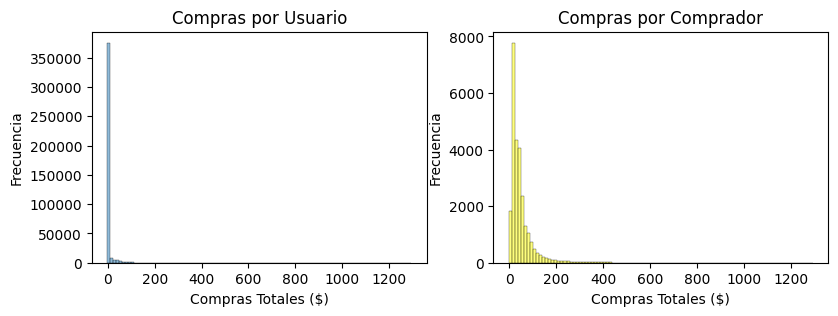

In [11]:
fig, ax = plt.subplots(1,2, figsize=(9.5, 3))
sns.histplot(users_df["total_sales"], bins=100, label=f"Distribución de Compras por Usuario", ax=ax[0], alpha=0.5)
sns.histplot(users_df.loc[users_df["has_purchases"]==1]["total_sales"], bins=100, label=f"Distribución de Compras por Comprador", ax=ax[1], alpha=0.5, color="yellow")

ax[0].set_title("Compras por Usuario")
ax[0].set_xlabel('Compras Totales ($)')
ax[0].set_ylabel('Frecuencia')
ax[1].set_title("Compras por Comprador")
ax[1].set_xlabel('Compras Totales ($)')
ax[1].set_ylabel('Frecuencia')

## Normality Check
We'll use the bootstrap technique to get an idea of the theoretical distribution of the sample mean difference

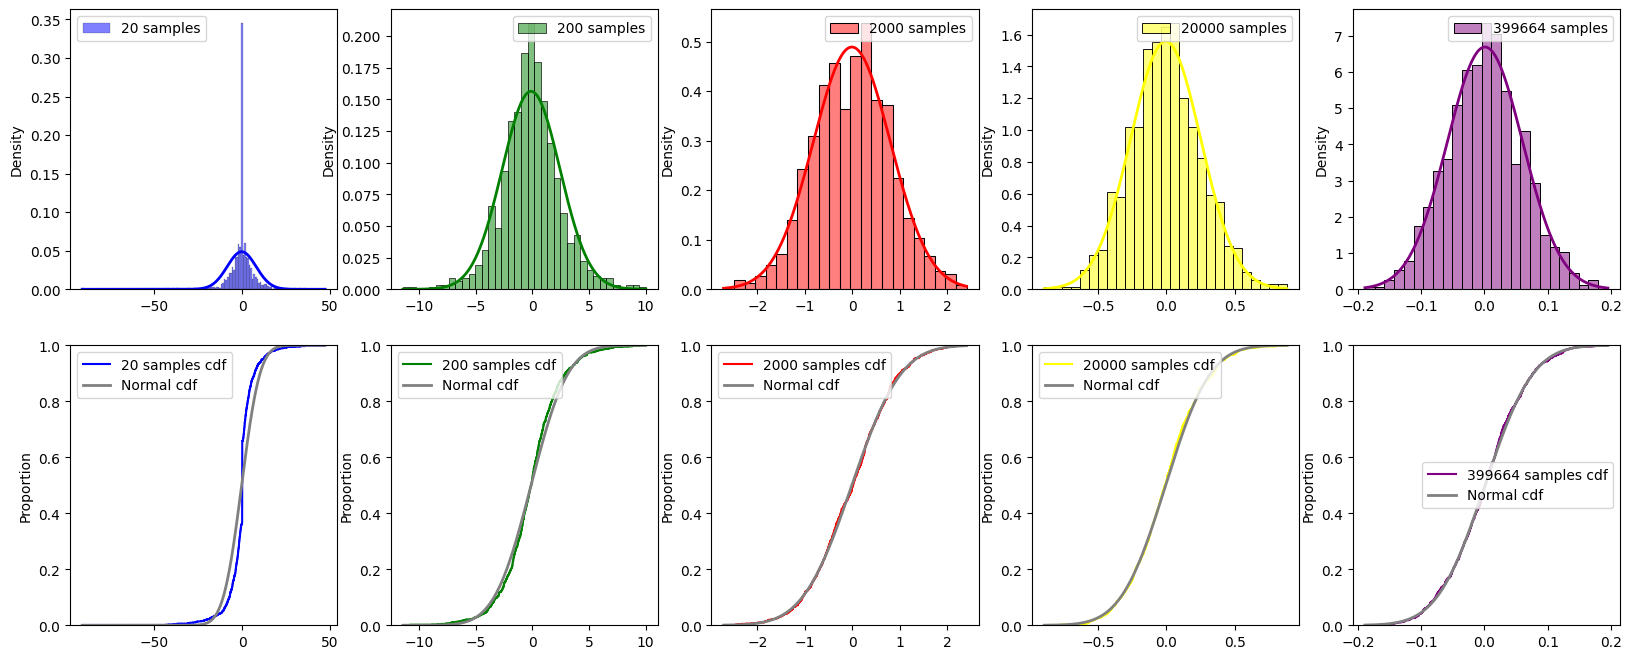

In [13]:
iterations = 1000
diff_dict = {}
samples = [20, 200, 2000, 20000, len(users_df)]
colors = ["blue", "green", "red", "yellow", "purple"]

fig, ax = plt.subplots(2,len(samples), figsize=(20, 8))

for i, s in enumerate(samples):
    diff_dict[f"{s}_samples"] = bootstrap_differences(users_df, variant_col="variant", value_col="total_sales", 
                                   iterations=iterations, num_samples=s)
    plot_norm_pdf(diff_dict[f"{s}_samples"], ax, i, s, colors[i])

In [14]:
#Run some normality tests
for s in samples:
    dagostino = stats.normaltest(diff_dict[f"{s}_samples"])
    shapiro = stats.shapiro(diff_dict[f"{s}_samples"])
    ks = stats.kstest(diff_dict[f"{s}_samples"], "norm")
    print(f"{s} samples:")
    print("D'agostino:", dagostino[1])
    print("Shapiro:", shapiro[1])
    print("Kolmogorov-Smirnoff:", dagostino[1])
    print("")
    


20 samples:
D'agostino: 1.1335510470958609e-104
Shapiro: 1.0023344820545641e-33
Kolmogorov-Smirnoff: 1.1335510470958609e-104

200 samples:
D'agostino: 1.6201600181415855e-09
Shapiro: 7.196913065499189e-10
Kolmogorov-Smirnoff: 1.6201600181415855e-09

2000 samples:
D'agostino: 0.9294354146567244
Shapiro: 0.7644609212875366
Kolmogorov-Smirnoff: 0.9294354146567244

20000 samples:
D'agostino: 0.11057033025316608
Shapiro: 0.22943013906478882
Kolmogorov-Smirnoff: 0.11057033025316608

399664 samples:
D'agostino: 0.6932948177945333
Shapiro: 0.7512120008468628
Kolmogorov-Smirnoff: 0.6932948177945333



KeyboardInterrupt: 

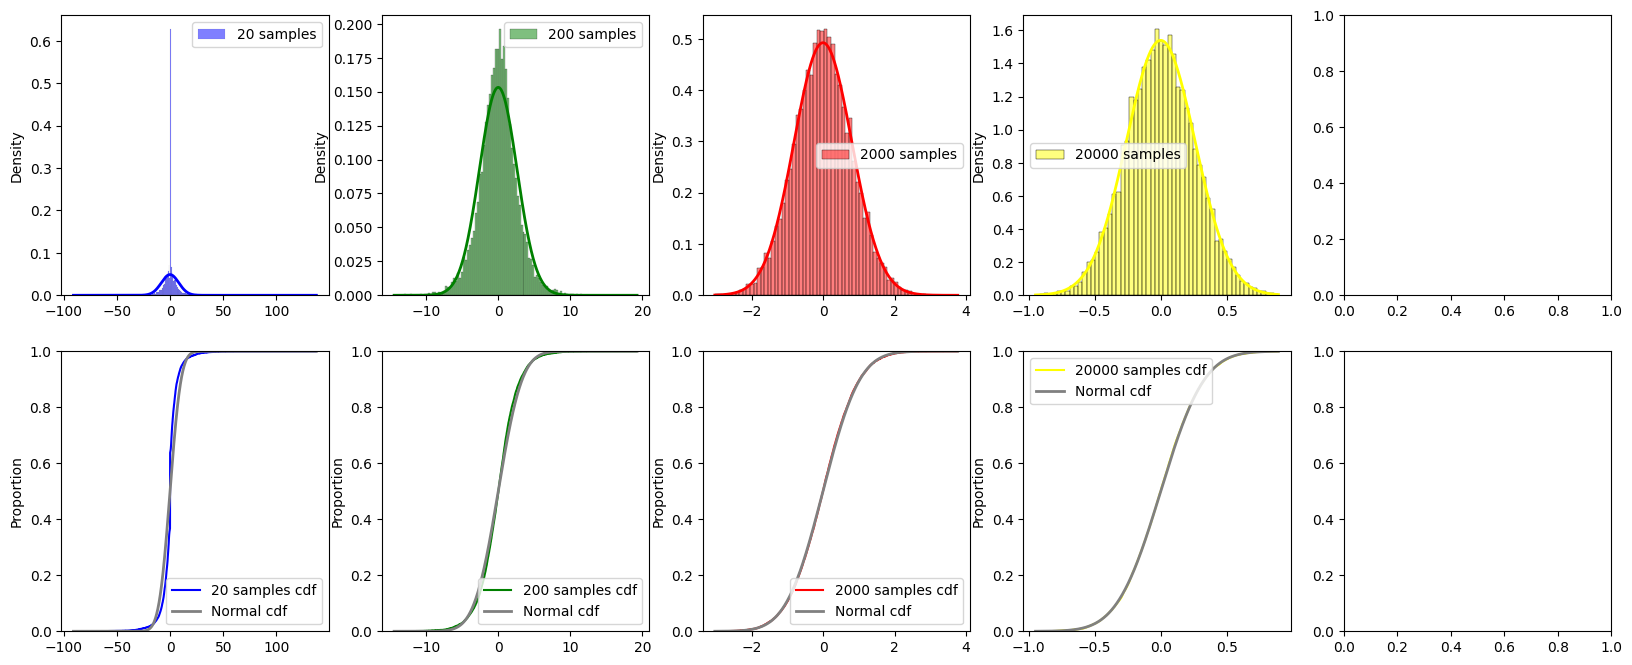

In [15]:
iterations = 10000
diff_dict = {}
samples = [20, 200, 2000, 20000, len(users_df)]
colors = ["blue", "green", "red", "yellow", "purple"]

fig, ax = plt.subplots(2,len(samples), figsize=(20, 8))

for i, s in enumerate(samples):
    diff_dict[f"{s}_samples"] = bootstrap_differences(users_df, variant_col="variant", value_col="total_sales", 
                                   iterations=iterations, num_samples=s)
    plot_norm_pdf(diff_dict[f"{s}_samples"], ax, i, s, colors[i])

In [ ]:
#Run some normality tests
for s in samples:
    dagostino = stats.normaltest(diff_dict[f"{s}_samples"])
    shapiro = stats.shapiro(diff_dict[f"{s}_samples"])
    ks = stats.kstest(diff_dict[f"{s}_samples"], "norm")
    print(f"{s} samples:")
    print("D'agostino:", dagostino[1])
    print("Shapiro:", shapiro[1])
    print("Kolmogorov-Smirnoff:", dagostino[1])
    print("")
    


20 samples:
D'agostino: 0.0
Shapiro: 0.0
Kolmogorov-Smirnoff: 0.0

200 samples:
D'agostino: 6.007678096962639e-107
Shapiro: 2.3487469971833585e-33
Kolmogorov-Smirnoff: 6.007678096962639e-107

2000 samples:
D'agostino: 0.0013464597853985228
Shapiro: 0.012865136377513409
Kolmogorov-Smirnoff: 0.0013464597853985228

20000 samples:
D'agostino: 0.6048693825247756
Shapiro: 0.624127984046936
Kolmogorov-Smirnoff: 0.6048693825247756

399664 samples:
D'agostino: 0.7648463544257635
Shapiro: 0.3442957103252411
Kolmogorov-Smirnoff: 0.7648463544257635



/Users/batiferraro/Documents/venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_68221/3055322139.py:14: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(bootstrap_df, x="iterations", y="p-value", hue="samples", palette=sns.color_palette("cubehelix"), alpha=0.8, linewidth=2)


Text(0.5, 1.0, 'p-value of Schapiro normality test by number of samples and iterations')

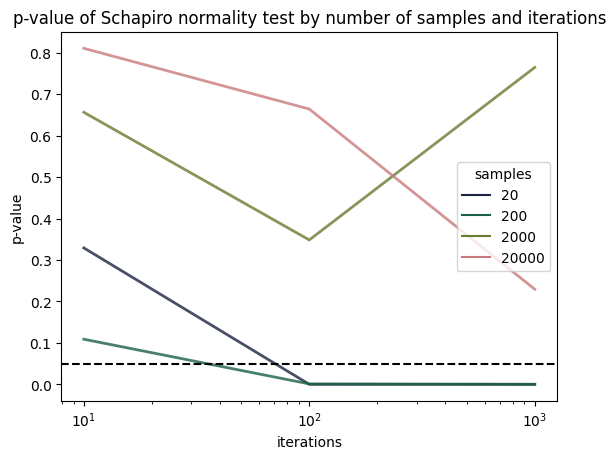

In [ ]:
#Check the shapiro test for different combinations of number of samples and iterations
samples = [20, 200, 2000, 20000]
iterations = [10, 100, 1000, 10000]
bootstrap_df = pd.DataFrame()

for s in samples:
    for i in iterations:
        this_bootstrap = bootstrap_differences(users_df, variant_col="variant", value_col="total_sales", 
                                   iterations=i, num_samples=s)
        shapiro = stats.shapiro(this_bootstrap)
        this_df = pd.DataFrame([{"samples":s, "iterations":i, "p-value":round(shapiro[1], 4)}])
        bootstrap_df = pd.concat([bootstrap_df, this_df])

sns.lineplot(bootstrap_df, x="iterations", y="p-value", hue="samples", palette=sns.color_palette("cubehelix"), alpha=0.8, linewidth=2)
plt.axhline(0.05, ls='--', color="black")
plt.xscale('log')
plt.title("p-value of Schapiro normality test by number of samples and iterations")


The problem with normality testing is that given enough samples, **we will always end un rejecting the null hypothesis** given that real world data doesn't really come from a normal distribution. Therefore, to decide if we can use CLT, **we'll rely on a visual inspection on the pdf and cdf** of the observed and thoretical distribution.

## p-values
We'll bootstrap again in an AA test to check if the p-values under the null hypothesys are uniformely distributed

### AA - low n

In [51]:
iterations = 1000
samples = 130

p_values_AA = run_test_mean_diff(users_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=iterations, num_samples=samples, alternative="greater")
p_values_AA = p_values_AA.reset_index(drop=True)
p_values_AA.head()

,test_number,t_score,p_value,reject_null
0,0,-1.356223,0.911292,False
1,1,-0.956956,0.829803,False
2,2,-1.070506,0.856797,False
3,3,0.576252,0.282728,False
4,4,0.894589,0.186343,False


auc p-value: 0.48974282641054295


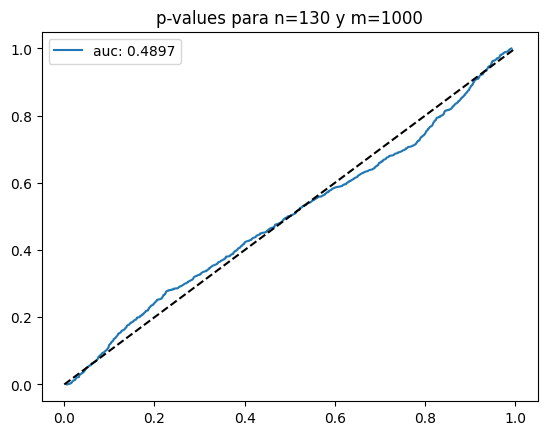

In [53]:
auc_value = auc(sorted(p_values_AA["p_value"]), np.linspace(0, 1, iterations))
print(f"auc p-value: {auc_value}")

fig, ax = plt.subplots()
ax.plot(sorted(p_values_AA[f"p_value"]), np.linspace(0, 1, iterations), label=f"auc: {round(auc_value,4)}")
ax.set_title("p-values para n=130 y m=1000")
ax.legend()
ax.plot([0,1],[0,1], '--k')

### AA - high n

In [54]:
iterations = 1000
samples = 2000

p_values_AA = run_test_mean_diff(users_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=iterations, num_samples=samples, alternative="greater")
p_values_AA = p_values_AA.reset_index(drop=True)
p_values_AA.head()

,test_number,t_score,p_value,reject_null
0,0,0.454387,0.324800,False
1,1,-1.647633,0.950207,False
2,2,-0.597982,0.725040,False
3,3,1.465262,0.071503,False
4,4,0.427184,0.334646,False


auc p-value: 0.4972801989908008


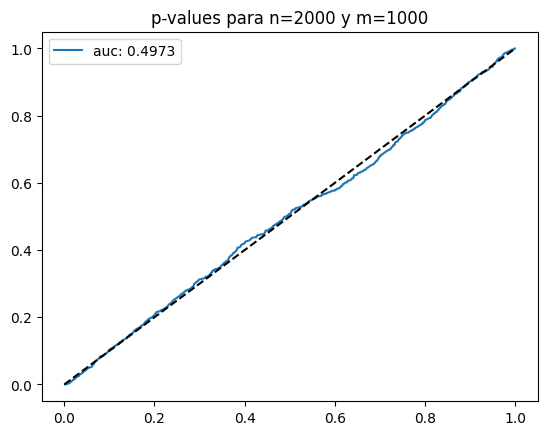

In [56]:
auc_value = auc(sorted(p_values_AA["p_value"]), np.linspace(0, 1, iterations))
print(f"auc p-value: {auc_value}")

fig, ax = plt.subplots()
ax.plot(sorted(p_values_AA[f"p_value"]), np.linspace(0, 1, iterations), label=f"auc: {round(auc_value,4)}")
ax.legend()
ax.set_title("p-values para n=2000 y m=1000")
ax.plot([0,1],[0,1], '--k')

### AB
Probamos simulando un aumento de las ventas bajo un tratamiento para ver cómo se modifica la curva

In [49]:
iterations = 1000
samples = 2000

p_values_AB = run_test_mean_diff(users_df, variant_col="variant", value_col="total_sales", 
                                          number_of_tests=iterations, num_samples=samples, alternative="greater", effect=0.5)
p_values_AB = p_values_AB.reset_index(drop=True)
p_values_AB.head()

,test_number,t_score,p_value,reject_null
0,0,2.231131,0.012892,True
1,1,-0.281544,0.610839,False
2,2,0.791083,0.214495,False
3,3,2.805436,0.002537,True
4,4,1.522904,0.063971,False


auc p-value: 0.8186364498232028


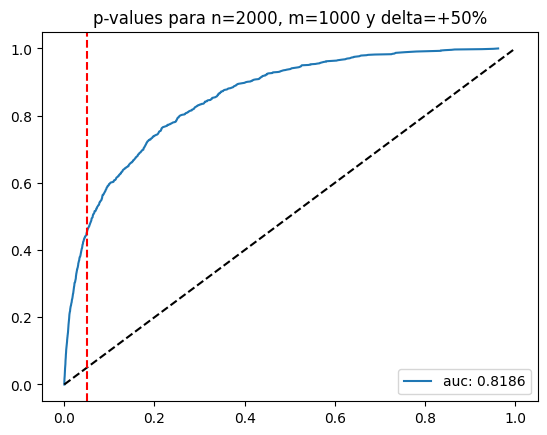

In [50]:
auc_value = auc(sorted(p_values_AB["p_value"]), np.linspace(0, 1, iterations))
print(f"auc p-value: {auc_value}")

fig, ax = plt.subplots()
ax.plot(sorted(p_values_AB["p_value"]), np.linspace(0, 1, iterations), label=f"auc: {round(auc_value,4)}")
ax.legend()
ax.set_title("p-values para n=2000, m=1000 y delta=+50%")
ax.plot([0,1],[0,1], '--k')
ax.axvline(0.05, ls='--', color="red")